In [22]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [24]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [25]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [26]:
tf.keras.backend.clear_session()

In [27]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [28]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
0,2003-1,28.193,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,2.461633,1004.196778,1442.873185,27.426715,23.514215,80.129958,1.496354,4.754469e+07,2.519796e+06,12.490621,4.318518e+07
1,2003-2,31.226,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,2.146644,1004.285479,1391.485021,27.434102,23.570112,80.319163,1.471632,4.760190e+07,2.521321e+06,12.492164,4.320154e+07
2,2003-3,33.484,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,1.545734,1004.424961,1387.248485,27.526483,23.615365,80.038754,1.428285,4.765911e+07,2.522846e+06,12.493707,4.321789e+07
3,2003-4,31.596,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,1.206698,1004.332351,1340.459254,28.123201,23.527731,77.082237,1.508691,4.771632e+07,2.524370e+06,12.495250,4.323425e+07
4,2003-5,32.919,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,1.173366,1004.223700,1275.514006,28.489089,23.459733,75.294378,1.484881,4.777353e+07,2.525895e+06,12.496793,4.325060e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.151933,1004.401766,1659.942363,27.956809,23.282197,76.850509,1.312771,NaN,NaN,NaN,NaN
260,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.266603,1004.068823,1622.940044,27.801480,23.272894,77.569036,1.286434,NaN,NaN,NaN,NaN
261,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.962768,1003.925169,1612.310209,27.732215,23.353608,78.118024,1.326979,NaN,NaN,NaN,NaN
262,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.913028,1003.994132,1578.456147,27.576622,23.466264,79.329993,1.384351,NaN,NaN,NaN,NaN


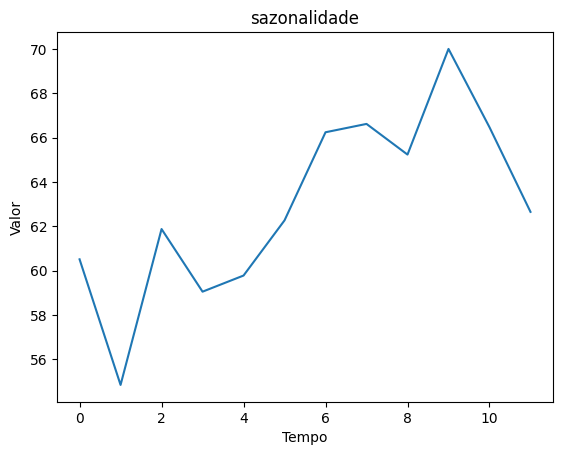

,sazonalidade
sazonalidade,
0,60.508000
1,54.841143
2,61.873571
3,59.048286
4,59.775929
5,62.265429
6,66.240154
7,66.616846
8,65.233385


In [29]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [30]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,2.461633,1004.196778,1442.873185,27.426715,23.514215,80.129958,1.496354,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,60.508000,28.193
1,2003-2,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,2.146644,1004.285479,1391.485021,27.434102,23.570112,80.319163,1.471632,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,54.841143,31.226
2,2003-3,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,1.545734,1004.424961,1387.248485,27.526483,23.615365,80.038754,1.428285,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,61.873571,33.484
3,2003-4,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,1.206698,1004.332351,1340.459254,28.123201,23.527731,77.082237,1.508691,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,59.048286,31.596
4,2003-5,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,1.173366,1004.223700,1275.514006,28.489089,23.459733,75.294378,1.484881,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,59.775929,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.151933,1004.401766,1659.942363,27.956809,23.282197,76.850509,1.312771,NaN,NaN,NaN,NaN,66.616846,NaN
260,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.266603,1004.068823,1622.940044,27.801480,23.272894,77.569036,1.286434,NaN,NaN,NaN,NaN,65.233385,NaN
261,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.962768,1003.925169,1612.310209,27.732215,23.353608,78.118024,1.326979,NaN,NaN,NaN,NaN,70.000154,NaN
262,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.913028,1003.994132,1578.456147,27.576622,23.466264,79.329993,1.384351,NaN,NaN,NaN,NaN,66.466615,NaN


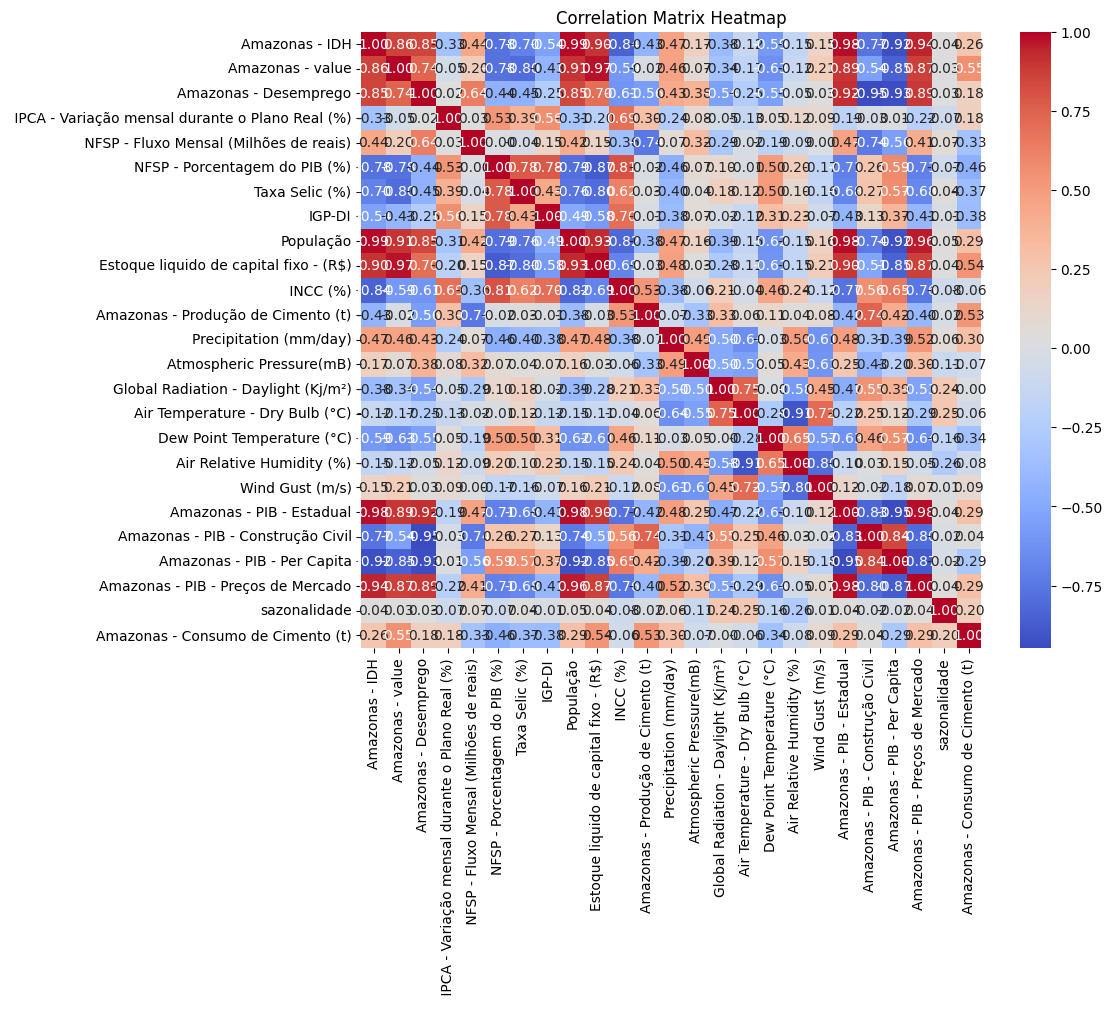

In [31]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [32]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,1004.196778,23.514215,1.496354,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,60.508000,28.193
1,2003-2,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,1004.285479,23.570112,1.471632,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,54.841143,31.226
2,2003-3,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,1004.424961,23.615365,1.428285,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,61.873571,33.484
3,2003-4,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,1004.332351,23.527731,1.508691,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,59.048286,31.596
4,2003-5,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,1004.223700,23.459733,1.484881,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,59.775929,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1004.401766,23.282197,1.312771,NaN,NaN,NaN,NaN,66.616846,NaN
260,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1004.068823,23.272894,1.286434,NaN,NaN,NaN,NaN,65.233385,NaN
261,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.925169,23.353608,1.326979,NaN,NaN,NaN,NaN,70.000154,NaN
262,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.994132,23.466264,1.384351,NaN,NaN,NaN,NaN,66.466615,NaN


In [33]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade
0,-2.017357,-1.841109,-0.841381,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.246822,0.160757,1.045542,0.153651,-1.725325,0.115495,1.032096,-1.955531,-0.615710
1,-1.988164,-1.831498,-0.844328,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.217639,0.226979,1.126598,0.078104,-1.704856,0.145069,1.057757,-1.907364,-2.038783
2,-1.958970,-1.829607,-0.847276,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.221378,0.331114,1.192219,-0.054362,-1.684387,0.174644,1.083417,-1.859197,-0.272785
3,-1.929776,-1.824180,-0.850223,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.207299,0.261973,1.065142,0.191353,-1.663918,0.204218,1.109077,-1.811030,-0.982277
4,-1.900583,-1.819720,-0.853171,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.183234,0.180856,0.966539,0.118592,-1.643449,0.233793,1.134738,-1.762863,-0.799550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.146285,0.624622,1.092028,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-2.063199,0.506250,-1.099221,-0.073135,1.193835,-1.214518,-0.726615,1.324047,0.918356
188,1.136919,0.664868,1.088543,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-2.019550,0.245652,-0.995183,-0.033052,1.186279,-1.186673,-0.718777,1.320189,0.570938
189,1.127552,0.713988,1.085058,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-1.981485,0.250516,-0.812204,-0.040116,1.178724,-1.158827,-0.710938,1.316331,1.767979
190,1.118186,0.765366,1.081573,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-1.940641,0.358572,-0.567789,-0.177231,1.171169,-1.130982,-0.703100,1.312472,0.880629


In [34]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      34.293
1      48.623
2      34.555
3      57.805
4      39.036
        ...  
259       NaN
260       NaN
261       NaN
262       NaN
263       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 264, dtype: float64

In [35]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade
0,-2.017357,-1.841109,-0.841381,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.246822,0.160757,1.045542,0.153651,-1.725325,0.115495,1.032096,-1.955531,-0.615710
1,-1.988164,-1.831498,-0.844328,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.217639,0.226979,1.126598,0.078104,-1.704856,0.145069,1.057757,-1.907364,-2.038783
2,-1.958970,-1.829607,-0.847276,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.221378,0.331114,1.192219,-0.054362,-1.684387,0.174644,1.083417,-1.859197,-0.272785
3,-1.929776,-1.824180,-0.850223,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.207299,0.261973,1.065142,0.191353,-1.663918,0.204218,1.109077,-1.811030,-0.982277
4,-1.900583,-1.819720,-0.853171,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.183234,0.180856,0.966539,0.118592,-1.643449,0.233793,1.134738,-1.762863,-0.799550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.448925,0.452650,1.390527,-0.214006,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,-0.823205,0.318967,0.251433,0.429271,1.169567,-1.503954,-1.462487,0.955680,-2.038783
158,1.452046,0.404414,1.372620,-0.434717,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,-0.905554,0.732801,0.350798,0.284080,1.175278,-1.511151,-1.435811,0.975593,-0.272785
159,1.455166,0.365711,1.354712,-0.524091,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,-0.983877,0.947048,0.095151,0.148965,1.180989,-1.518349,-1.409135,0.995507,-0.982277
160,1.458287,0.316318,1.336804,-0.614500,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-1.057189,1.210467,-0.282049,0.079540,1.186700,-1.525547,-1.382459,1.015420,-0.799550


In [36]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      34.293
1      48.623
2      34.555
3      57.805
4      39.036
        ...  
157    44.068
158    62.847
159    30.374
160    60.003
161    81.014
Name: Amazonas - Consumo de Cimento (t), Length: 162, dtype: float64

In [37]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [38]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 20)

In [39]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade
126,0.555057,1.274691,0.945132,0.888984,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,0.563099,0.747610,-1.409241,-0.098694,0.801569,-0.466491,-0.864199,0.860635,0.823760
127,0.563987,1.302840,0.969467,0.954254,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,0.502599,0.307049,-1.301890,-0.042678,0.817293,-0.522440,-0.912686,0.854184,0.918356
128,0.572918,1.321485,0.993802,1.045217,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,0.402261,0.004531,-1.215911,0.011665,0.833017,-0.578389,-0.961174,0.847732,0.570938
129,0.581848,1.339108,1.018136,1.176395,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,0.355033,-0.182572,-1.070122,0.078605,0.848741,-0.634338,-1.009662,0.841281,1.767979
130,0.590779,1.353338,1.042471,1.303259,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,0.291284,-0.311933,-0.702230,0.093345,0.864466,-0.690287,-1.058150,0.834830,0.880629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.146285,0.624622,1.092028,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-2.063199,0.506250,-1.099221,-0.073135,1.193835,-1.214518,-0.726615,1.324047,0.918356
188,1.136919,0.664868,1.088543,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-2.019550,0.245652,-0.995183,-0.033052,1.186279,-1.186673,-0.718777,1.320189,0.570938
189,1.127552,0.713988,1.085058,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-1.981485,0.250516,-0.812204,-0.040116,1.178724,-1.158827,-0.710938,1.316331,1.767979
190,1.118186,0.765366,1.081573,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-1.940641,0.358572,-0.567789,-0.177231,1.171169,-1.130982,-0.703100,1.312472,0.880629


In [40]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 20)

In [41]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [42]:
# Rede Neural Recorrente com optmizador Estocástico
def bidirectional_lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [43]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(2)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = bidirectional_lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [44]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[768322893, 282560761]


Step: 0 ___________________________________________


2023-10-20 23:48:22.486367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 23:48:22.486538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 23:48:22.486675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 135.77310180664062
winner_seed: 768322893


Step: 1 ___________________________________________
val_loss: 114.09963989257812
winner_seed: 282560761


final_seed: 282560761


In [45]:
trained_model, history = bidirectional_lstm_model(reshaped_train, 
                                                  reshaped_target, 
                                                  want_verbose=1, 
                                                  seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 128ms/step - loss: 4140.6338 - val_loss: 126.9433
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 282.4446 - val_loss: 392.7833
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 195.6445 - val_loss: 359.2236
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 406.6837 - val_loss: 337.8106
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 998.5462 - val_loss: 272.3732
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 205.2156 - val_loss: 253.0426
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 145.4036 - val_loss: 228.5388
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 132.8356 - val_loss: 160.5007
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 129.5531 - val_loss: 161.1365
Epoch 10/10000
4/4 [==============================] - 0s 12ms/

4/4 [==============================] - 0s 11ms/step - loss: 94.0131 - val_loss: 151.6780
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.5603 - val_loss: 162.4962
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 103.6964 - val_loss: 169.6426
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.6194 - val_loss: 177.0324
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 96.1360 - val_loss: 171.2057
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.9524 - val_loss: 165.7406
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 93.1460 - val_loss: 160.5224
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.4181 - val_loss: 161.2081
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 89.2028 - val_loss: 150.3528
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.

4/4 [==============================] - 0s 12ms/step - loss: 82.6034 - val_loss: 173.1190
Epoch 158/10000
4/4 [==============================] - 0s 12ms/step - loss: 83.0062 - val_loss: 159.7136
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 83.7056 - val_loss: 176.3297
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 86.4910 - val_loss: 166.4472
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 80.0634 - val_loss: 163.0231
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.9603 - val_loss: 158.8737
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 80.9202 - val_loss: 162.2068
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.3774 - val_loss: 164.4765
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 78.6030 - val_loss: 157.7599
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 71.9016 - val_loss: 147.1870
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 77.9096 - val_loss: 139.5884
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 77.4324 - val_loss: 168.8139
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.8380 - val_loss: 149.4442
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 73.9266 - val_loss: 162.8527
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 89.9507 - val_loss: 155.6883
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.6482 - val_loss: 169.7526
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.1064 - val_loss: 158.6714
Epoch 243/10000
4/4 [==============================] - 0s 10ms/step - loss: 72.2264 - val_loss: 171.1909
Epoch 244/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 68.5558 - val_loss: 153.7796
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.1958 - val_loss: 170.5128
Epoch 315/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.4290 - val_loss: 158.6933
Epoch 316/10000
4/4 [==============================] - 0s 12ms/step - loss: 62.9487 - val_loss: 161.8179
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 66.2721 - val_loss: 163.4283
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 66.5741 - val_loss: 163.7480
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.2904 - val_loss: 177.4334
Epoch 320/10000
4/4 [==============================] - 0s 12ms/step - loss: 70.9514 - val_loss: 147.6201
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.0386 - val_loss: 158.2546
Epoch 322/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 60.6335 - val_loss: 163.6829
Epoch 392/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.3732 - val_loss: 148.6931
Epoch 393/10000
4/4 [==============================] - 0s 12ms/step - loss: 44.6421 - val_loss: 157.7094
Epoch 394/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.0611 - val_loss: 155.0159
Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.6352 - val_loss: 168.1637
Epoch 396/10000
4/4 [==============================] - 0s 10ms/step - loss: 51.2718 - val_loss: 148.6917
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step - loss: 48.6894 - val_loss: 154.7958
Epoch 398/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.1727 - val_loss: 156.7631
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.5067 - val_loss: 151.6166
Epoch 400/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 29.2229 - val_loss: 158.8367
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.2627 - val_loss: 156.3563
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.4520 - val_loss: 154.0968
Epoch 472/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.0612 - val_loss: 165.3531
Epoch 473/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.7073 - val_loss: 165.1343
Epoch 474/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.8174 - val_loss: 157.5180
Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.2931 - val_loss: 166.1437
Epoch 476/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.1025 - val_loss: 166.7537
Epoch 477/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.5951 - val_loss: 160.4261
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 26.0980 - val_loss: 159.7595
Epoch 548/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.5926 - val_loss: 151.4807
Epoch 549/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.7942 - val_loss: 158.8156
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.3158 - val_loss: 157.7073
Epoch 551/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.7205 - val_loss: 154.6511
Epoch 552/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.2877 - val_loss: 154.1154
Epoch 553/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.0914 - val_loss: 153.1060
Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1458 - val_loss: 153.0723
Epoch 555/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.9569 - val_loss: 160.4909
Epoch 556/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 24.6816 - val_loss: 151.5842
Epoch 626/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.2637 - val_loss: 151.2527
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.6386 - val_loss: 163.5389
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.4361 - val_loss: 156.1847
Epoch 629/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.4502 - val_loss: 165.2567
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.7830 - val_loss: 158.8022
Epoch 631/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.2777 - val_loss: 156.5350
Epoch 632/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.5306 - val_loss: 156.6664
Epoch 633/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.0461 - val_loss: 154.6850
Epoch 634/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 23.1298 - val_loss: 149.8585
Epoch 704/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.7596 - val_loss: 146.7063
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.0825 - val_loss: 145.7679
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.8419 - val_loss: 150.3122
Epoch 707/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.2399 - val_loss: 146.2844
Epoch 708/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.2120 - val_loss: 146.9917
Epoch 709/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.3817 - val_loss: 148.1332
Epoch 710/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.9147 - val_loss: 149.6902
Epoch 711/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.7501 - val_loss: 147.2069
Epoch 712/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 17.6988 - val_loss: 146.2408
Epoch 782/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.1796 - val_loss: 148.8150
Epoch 783/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.9833 - val_loss: 144.3855
Epoch 784/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.1875 - val_loss: 150.2715
Epoch 785/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.0566 - val_loss: 147.0233
Epoch 786/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.1203 - val_loss: 147.7816
Epoch 787/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.1944 - val_loss: 145.4756
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.5972 - val_loss: 147.3415
Epoch 789/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.2558 - val_loss: 145.1073
Epoch 790/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 19.3831 - val_loss: 143.1347
Epoch 860/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.8073 - val_loss: 139.6579
Epoch 861/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.9227 - val_loss: 138.4924
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.0149 - val_loss: 144.5052
Epoch 863/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.0093 - val_loss: 141.7694
Epoch 864/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.1138 - val_loss: 142.0050
Epoch 865/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.7073 - val_loss: 142.2478
Epoch 866/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.4993 - val_loss: 140.7570
Epoch 867/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.9494 - val_loss: 140.2053
Epoch 868/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 17.8499 - val_loss: 134.5483
Epoch 938/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.0686 - val_loss: 136.4044
Epoch 939/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.3521 - val_loss: 140.5326
Epoch 940/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.1760 - val_loss: 138.1931
Epoch 941/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.1360 - val_loss: 139.2851
Epoch 942/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.6900 - val_loss: 138.7948
Epoch 943/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.0760 - val_loss: 138.1384
Epoch 944/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.4207 - val_loss: 137.7899
Epoch 945/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.4973 - val_loss: 138.7165
Epoch 946/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 12.4842 - val_loss: 143.5567
Epoch 1016/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.0263 - val_loss: 139.7904
Epoch 1017/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.1166 - val_loss: 142.7472
Epoch 1018/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.3817 - val_loss: 139.5406
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.9009 - val_loss: 140.1529
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.2274 - val_loss: 140.3728
Epoch 1021/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8039 - val_loss: 140.7912
Epoch 1022/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.1048 - val_loss: 141.2504
Epoch 1023/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.6921 - val_loss: 139.6933
Epoch 1024/10000
4/4 [==============================] - 0s 10ms/ste

4/4 [==============================] - 0s 10ms/step - loss: 17.9767 - val_loss: 141.4318
Epoch 1093/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.5386 - val_loss: 137.6741
Epoch 1094/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.6739 - val_loss: 141.3807
Epoch 1095/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.7357 - val_loss: 138.4914
Epoch 1096/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.8297 - val_loss: 141.8393
Epoch 1097/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0450 - val_loss: 138.5274
Epoch 1098/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.7364 - val_loss: 139.7801
Epoch 1099/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2591 - val_loss: 149.7781
Epoch 1100/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.0739 - val_loss: 139.0799
Epoch 1101/10000
4/4 [==============================] - 0s 9ms/s

Epoch 1170/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.6056 - val_loss: 140.1550
Epoch 1171/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.7298 - val_loss: 138.6153
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3990 - val_loss: 137.1693
Epoch 1173/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7974 - val_loss: 139.9180
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.0800 - val_loss: 139.0882
Epoch 1175/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.4115 - val_loss: 138.4810
Epoch 1176/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0362 - val_loss: 137.3320
Epoch 1177/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.6248 - val_loss: 136.6192
Epoch 1178/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.2862 - val_loss: 136.8783
Epoch 1179/10000
4/4 [==============================] -

In [46]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [47]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,52.520714,53.251457,53.50666,53.429214,53.981659,53.56012,48.792988,48.001358,47.603275,48.785381,49.660549,50.623772,51.834938,52.491547,51.291328,49.868145,50.94294,50.619087,48.656647,47.262596,46.177586,46.54932,47.23365,48.313332,49.426395,50.389191,50.416817,49.666786,49.271782,48.264511
Target,64.862,49.885,53.13,57.796,47.026,74.919,34.733,15.022,20.879,36.409,22.277,20.529,37.061,23.387,38.399,39.652,40.204,21.625,42.731,36.026,34.609,40.787,39.823,39.957,52.048,53.567,46.239,51.066,51.684,44.907
Error,12.341286,3.366459,0.376659,4.366787,6.955658,21.358879,14.059986,32.979359,26.724276,12.376381,27.383549,30.094772,14.773937,29.104548,12.89233,10.216145,10.738941,28.994087,5.925648,11.236595,11.568584,5.762321,7.410648,8.356331,2.621605,3.177811,4.177818,1.399216,2.412216,3.35751


In [48]:
display(mae)
display(mape)

12.217011

0.44011

In [49]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [50]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[613.71716]] - Target[497.4669999999999]| =  Error: [[116.25015]]; MAPE:[[0.23368414]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[591.24115]] - Target[434.26099999999997]| =  Error: [[156.98016]]; MAPE:[[0.36148807]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[297.4355]] - Target[299.511]| =  Error: [[2.0755005]]; MAPE:[[0.00692963]]


[array([[116.25015]], dtype=float32),
 array([[156.98016]], dtype=float32),
 array([[2.0755005]], dtype=float32)]

91.76861

0.20070063